# Predicting Ljubljana' s real estate prizes
## Web scraping project

First we will import all the necessary libraries needed for data preprocessing and visualisation. 

%matplotlib inline sets the backend of matplotlib to the 'inline' backend:
With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

In [18]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import datapane as dp
import folium
%matplotlib inline

print(tf.__version__)

2.3.0


Data is from a website called nepremičnine.net and it was web scrapped.

Web scraping, web harvesting, or web data extraction is data scraping used for extracting data from websites. Web scraping software may access the World Wide Web directly using the Hypertext Transfer Protocol, or through a web browser. While web scraping can be done manually by a software user, the term typically refers to automated processes implemented using a bot or web crawler. It is a form of copying, in which specific data is gathered and copied from the web, typically into a central local database or spreadsheet, for later retrieval or analysis.

In [19]:
!ls *csv

generated_file.csv


In [20]:
df = pd.read_csv('generated_file.csv', delimiter ='|' )
df.head()

,title,offer_type,desc,size,price,gradnja,adaptacija
0,Ne spreglejte,trisobno,"74,5 m2, 3-sobno, zgrajeno l. 1964, adaptirano...","74,50 m2","890,00 €/mesec",1964.0,2020.0
1,Ne spreglejte,trisobno,"77 m2, 3-sobno, zgrajeno l. 1969, adaptirano l...","77,00 m2","750,00 €/mesec",1969.0,2015.0
2,Ne spreglejte,dvosobno,"60 m2, 2-sobno, zgrajeno l. 1935, adaptirano l...","60,00 m2","850,00 €/mesec",1935.0,2018.0
3,"BEŽIGRAJSKI DVOR, PERIČEVA ULICA 1",enosobno,"28 m2, 1-sobno, zgrajeno l. 1950, adaptirano l...","28,00 m2","400,00 €/mesec",1950.0,2007.0
4,BIZOVIK,trisobno,"100 m2, 3-sobno, zgrajeno l. 1977, adaptirano ...","100,00 m2","750,00 €/mesec",1977.0,2020.0


In [21]:
df.count()

title         1490
offer_type    1490
desc          1490
size          1490
price         1490
gradnja       1284
adaptacija     857
dtype: int64

In [22]:
df['gradnja'].isnull().sum()

206

In [23]:
df['adaptacija'].isnull().sum()

633

In [24]:
df.dtypes

title          object
offer_type     object
desc           object
size           object
price          object
gradnja       float64
adaptacija    float64
dtype: object

In [25]:
df.shape

(1490, 7)

In [26]:
index_names = df[df['title'] == 'Ne spreglejte' ].index 
df.drop(index_names, inplace = True) 


In [27]:
df = df.reset_index(drop=True)
df.head()

,title,offer_type,desc,size,price,gradnja,adaptacija
0,"BEŽIGRAJSKI DVOR, PERIČEVA ULICA 1",enosobno,"28 m2, 1-sobno, zgrajeno l. 1950, adaptirano l...","28,00 m2","400,00 €/mesec",1950.0,2007.0
1,BIZOVIK,trisobno,"100 m2, 3-sobno, zgrajeno l. 1977, adaptirano ...","100,00 m2","750,00 €/mesec",1977.0,2020.0
2,BIZOVIK,petsobno,"105,5 m2, 5 in večsobno, zgrajeno l. 2005, odd...","105,50 m2","1.500,00 €/mesec",2005.0,NaN
3,BRDO,Soba,"15 m2, soba, zgrajena l. 1970, adaptirana l. 2...","15,00 m2","250,00 €/mesec",1970.0,2003.0
4,BRDO,Soba,"15 m2, soba, zgrajena l. 2002, adaptirana l. 2...","15,00 m2","200,00 €/mesec",2002.0,2020.0


In [131]:
api_token ='ae261336f2f2d3f9ad41ce89f30e802d427bfd8a'
import datapane as dp
dp.login(token=api_token)

table = dp.Table(df[:100])
report = dp.Report(table)
report.publish(name="Ljubljana's apartments", visibility = 'PUBLIC')

Connected successfully to https://datapane.com as Timothy102
Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/Timothy102/reports/ljubljanas-apartments/


# Room factor

In [29]:
df['offer_type'].describe()

count         1487
unique          13
top       dvosobno
freq           286
Name: offer_type, dtype: object

As we can see offer_type is a categorical column which we will tranform into a numerical, but first we have to redo all the data, since there is no innate connection between 'oneroom' and 1 for computers. We will look at all the possible options and rename them accordingly. 

In [30]:
df['offer_type'].unique()

array(['enosobno', 'trisobno', 'petsobno', 'Soba', 'dvosobno',
       'dvoinpolsobno', 'garsonjera', 'štirisobno', 'enoinpolsobno',
       'triinpolsobno', 'Apartma', 'Drugo', 'štiriinpolsobno'],
      dtype=object)

In [31]:
index_names = df[df['offer_type'] == 'Drugo' ].index 
df.drop(index_names, inplace = True) 
df.head()

,title,offer_type,desc,size,price,gradnja,adaptacija
0,"BEŽIGRAJSKI DVOR, PERIČEVA ULICA 1",enosobno,"28 m2, 1-sobno, zgrajeno l. 1950, adaptirano l...","28,00 m2","400,00 €/mesec",1950.0,2007.0
1,BIZOVIK,trisobno,"100 m2, 3-sobno, zgrajeno l. 1977, adaptirano ...","100,00 m2","750,00 €/mesec",1977.0,2020.0
2,BIZOVIK,petsobno,"105,5 m2, 5 in večsobno, zgrajeno l. 2005, odd...","105,50 m2","1.500,00 €/mesec",2005.0,NaN
3,BRDO,Soba,"15 m2, soba, zgrajena l. 1970, adaptirana l. 2...","15,00 m2","250,00 €/mesec",1970.0,2003.0
4,BRDO,Soba,"15 m2, soba, zgrajena l. 2002, adaptirana l. 2...","15,00 m2","200,00 €/mesec",2002.0,2020.0


In [32]:
df[df["offer_type"]=="Apartma"].head()

,title,offer_type,desc,size,price,gradnja,adaptacija
124,LJ. BEŽIGRAD,Apartma,"35 m2, apartma, zgrajen l. 2015, pritličje, Od...","35,00 m2","600,00 €/mesec",2015.0,NaN
279,LJ. CENTER,Apartma,"52 m2, apartma, zgrajen l. 1730, adaptiran l. ...","52,00 m2","700,00 €/mesec",1730.0,2018.0
650,LJ. ŠIŠKA,Apartma,"16 m2, apartma, zgrajen l. 1960, adaptiran l. ...","16,00 m2","200,00 €/mesec",1960.0,2020.0


In [33]:
df.loc[df['offer_type'] == 'enosobno', 'offer_type'] = 3
df.loc[df['offer_type'] == 'dvosobno', 'offer_type'] = 4 
df.loc[df['offer_type'] == 'trisobno', 'offer_type'] = 5
df.loc[df['offer_type'] == 'štirisobno', 'offer_type'] = 6
df.loc[df['offer_type'] == 'Soba', 'offer_type'] = 1
df.loc[df['offer_type'] == 'enoinpolsobno', 'offer_type'] = 3.5
df.loc[df['offer_type'] == 'dvoinpolsobno', 'offer_type'] = 4.5
df.loc[df['offer_type'] == 'štiriinpolsobno', 'offer_type'] = 6.5
df.loc[df['offer_type'] == 'triinpolsobno', 'offer_type'] = 5.5
df.loc[df['offer_type'] == 'garsonjera', 'offer_type'] = 2
df.loc[df['offer_type'] == 'petsobno', 'offer_type'] = 7
df.loc[df['offer_type'] == 'Apartma', 'offer_type'] = 3
df.head()

,title,offer_type,desc,size,price,gradnja,adaptacija
0,"BEŽIGRAJSKI DVOR, PERIČEVA ULICA 1",3,"28 m2, 1-sobno, zgrajeno l. 1950, adaptirano l...","28,00 m2","400,00 €/mesec",1950.0,2007.0
1,BIZOVIK,5,"100 m2, 3-sobno, zgrajeno l. 1977, adaptirano ...","100,00 m2","750,00 €/mesec",1977.0,2020.0
2,BIZOVIK,7,"105,5 m2, 5 in večsobno, zgrajeno l. 2005, odd...","105,50 m2","1.500,00 €/mesec",2005.0,NaN
3,BRDO,1,"15 m2, soba, zgrajena l. 1970, adaptirana l. 2...","15,00 m2","250,00 €/mesec",1970.0,2003.0
4,BRDO,1,"15 m2, soba, zgrajena l. 2002, adaptirana l. 2...","15,00 m2","200,00 €/mesec",2002.0,2020.0


In [34]:
df['offer_type'] = pd.to_numeric(df['offer_type'])
df.head()

,title,offer_type,desc,size,price,gradnja,adaptacija
0,"BEŽIGRAJSKI DVOR, PERIČEVA ULICA 1",3.0,"28 m2, 1-sobno, zgrajeno l. 1950, adaptirano l...","28,00 m2","400,00 €/mesec",1950.0,2007.0
1,BIZOVIK,5.0,"100 m2, 3-sobno, zgrajeno l. 1977, adaptirano ...","100,00 m2","750,00 €/mesec",1977.0,2020.0
2,BIZOVIK,7.0,"105,5 m2, 5 in večsobno, zgrajeno l. 2005, odd...","105,50 m2","1.500,00 €/mesec",2005.0,NaN
3,BRDO,1.0,"15 m2, soba, zgrajena l. 1970, adaptirana l. 2...","15,00 m2","250,00 €/mesec",1970.0,2003.0
4,BRDO,1.0,"15 m2, soba, zgrajena l. 2002, adaptirana l. 2...","15,00 m2","200,00 €/mesec",2002.0,2020.0


In [35]:
df = df.rename(columns={"title": "lokacija", "offer_type" : "room_factor"})
df.head()

,lokacija,room_factor,desc,size,price,gradnja,adaptacija
0,"BEŽIGRAJSKI DVOR, PERIČEVA ULICA 1",3.0,"28 m2, 1-sobno, zgrajeno l. 1950, adaptirano l...","28,00 m2","400,00 €/mesec",1950.0,2007.0
1,BIZOVIK,5.0,"100 m2, 3-sobno, zgrajeno l. 1977, adaptirano ...","100,00 m2","750,00 €/mesec",1977.0,2020.0
2,BIZOVIK,7.0,"105,5 m2, 5 in večsobno, zgrajeno l. 2005, odd...","105,50 m2","1.500,00 €/mesec",2005.0,NaN
3,BRDO,1.0,"15 m2, soba, zgrajena l. 1970, adaptirana l. 2...","15,00 m2","250,00 €/mesec",1970.0,2003.0
4,BRDO,1.0,"15 m2, soba, zgrajena l. 2002, adaptirana l. 2...","15,00 m2","200,00 €/mesec",2002.0,2020.0


## Location

In [36]:
df['lokacija'].astype('string')

0       BEŽIGRAJSKI DVOR, PERIČEVA ULICA 1
1                                  BIZOVIK
2                                  BIZOVIK
3                                     BRDO
4                                     BRDO
                       ...                
1482             ROŽNA DOLINA, VIŠKA CESTA
1483                             SP. ŠIŠKA
1484                               STOŽICE
1485                                 TACEN
1486      ZUPANČIČEVA JAMA, BLIŽINA CENTRA
Name: lokacija, Length: 1483, dtype: string

In [37]:
df['lokacija'].unique()

array(['BEŽIGRAJSKI DVOR, PERIČEVA ULICA 1', 'BIZOVIK', 'BRDO',
       'BRDO, NOVA GRBINA', 'BRDO, ZELENI GAJ', 'BRINJE, BEŽIGRAD',
       'BROD', 'BROD, PIPANOVA POT 14', 'BROD, POD ŠMARNO GORO',
       'BROD, TACEN', 'BS 3', 'BS 3, BEŽIGRAD', 'BS 3, LJ. BEŽIGRAD',
       'BS 3, MAROLTOVA ULICA 2', 'BS 3, VOJKOVA 77',
       'BS 3, VOJKOVA CESTA', 'BS 3, VOJKOVA CESTA 91', 'BTC', 'ČRNUČE',
       'ČRNUČE, CENETA ŠTUPARJA', 'ČRNUČE, LJ.', 'ČRNUČE, POLANŠKOVA',
       'ČRNUČE, SREDNJE GAMELJNE', 'ČRNUŠKA GMAJNA',
       'ČRNUŠKA GMAJNA, ČRNUČE, POLANŠKOVA ULICA', 'DOBRUNJE',
       'DOLGI MOST', 'DOLGI MOST, NASELJE KOZARJE', 'DRAVELJSKA GMAJNA',
       'DRAVLJE', 'DRAVLJE, BLIZU DRAVELJSKE CERKVE',
       'DRAVLJE, BRILEJEVA - NASPROTI MERCATOR CENT',
       'DRAVLJE, KAMNOGORIŠKA CESTA', 'DRAVLJE, LJ. - DRAVELJSKA GMAJNA',
       'DRAVLJE, PILONOVA 8', 'DRAVLJE, UL. BRATOV BABNIK', 'FUŽINE',
       'FUŽINE, BRODARJEV TRG', 'FUŽINE, CHENGDUJSKA ULICA 24',
       'FUŽINE, OBNOVLJENO 202

In [38]:
df['lokacija'].str.replace('LJ.','')
df.head()

,lokacija,room_factor,desc,size,price,gradnja,adaptacija
0,"BEŽIGRAJSKI DVOR, PERIČEVA ULICA 1",3.0,"28 m2, 1-sobno, zgrajeno l. 1950, adaptirano l...","28,00 m2","400,00 €/mesec",1950.0,2007.0
1,BIZOVIK,5.0,"100 m2, 3-sobno, zgrajeno l. 1977, adaptirano ...","100,00 m2","750,00 €/mesec",1977.0,2020.0
2,BIZOVIK,7.0,"105,5 m2, 5 in večsobno, zgrajeno l. 2005, odd...","105,50 m2","1.500,00 €/mesec",2005.0,NaN
3,BRDO,1.0,"15 m2, soba, zgrajena l. 1970, adaptirana l. 2...","15,00 m2","250,00 €/mesec",1970.0,2003.0
4,BRDO,1.0,"15 m2, soba, zgrajena l. 2002, adaptirana l. 2...","15,00 m2","200,00 €/mesec",2002.0,2020.0


In [39]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_user_agent")
city ="Ljubljana"
country ="Slovenia"
loc = geolocator.geocode(city+','+ country)
print("latitude is :-" ,loc.latitude,"\nlongtitude is:-" ,loc.longitude)

latitude is :- 46.0499803 
longtitude is:- 14.5068602


In [40]:
center = (loc.latitude, loc.longitude)
center

(46.0499803, 14.5068602)

In [41]:
df['lokacija'].isnull().sum()

0

In [42]:
from geopy.distance import great_circle
newport_ri = (41.49008, -71.312796)

cleveland_oh = (41.499498, -81.695391)
print(great_circle(newport_ri, cleveland_oh).km)

864.2144943393625


In [43]:
def create_tuple(x, number):
    loc = geolocator.geocode(x)
    if loc is not None:
        return (loc.latitude, loc.longitude)
    else:
        return (number, number)

dun_cesta = geolocator.geocode('DUNAJSKA CESTA')
print(great_circle(center, create_tuple(dun_cesta,5)))

0.9304784133255821 km


In [44]:
df.tail()

,lokacija,room_factor,desc,size,price,gradnja,adaptacija
1482,"ROŽNA DOLINA, VIŠKA CESTA",4.5,"67,2 m2, 2,5-sobno, zgrajeno l. 1967, oddamo. ...","67,20 m2","700,00 €/mesec",1967.0,NaN
1483,SP. ŠIŠKA,3.5,"46 m2, 1,5-sobno, adaptirano l. 2015, 10 m2 ze...","46,00 m2","540,00 €/mesec",NaN,2015.0
1484,STOŽICE,3.0,"42,4 m2, 1-sobno, zgrajeno l. 2001, 2. nad., o...","42,40 m2","450,00 €/mesec",2001.0,NaN
1485,TACEN,5.0,"85 m2, 3-sobno, zgrajeno l. 1990, pritličje, o...","85,00 m2","680,00 €/mesec",1990.0,NaN
1486,"ZUPANČIČEVA JAMA, BLIŽINA CENTRA",1.0,"18,78 m2, soba, zgrajena l. 1935, adaptirana l...","18,78 m2","165,00 €/mesec",1935.0,2019.0


In [45]:
data_size = df.count()[0]
data_size

1483

In [46]:
df['latitude'] = df['lokacija'].apply(lambda x: create_tuple(x,46)[0])
df['longitude'] = df['lokacija'].apply(lambda x: create_tuple(x,14.5)[1])

At this point, we can already get rid of the description column. That will shorten the amount of data pandas has to hold in memory. If you pay attention, you'll notice that the description column contains all the data that was afterwards splitted into columns. 

In [47]:
df.drop('desc',inplace=True, axis=1)
df.head()

,lokacija,room_factor,size,price,gradnja,adaptacija,latitude,longitude
0,"BEŽIGRAJSKI DVOR, PERIČEVA ULICA 1",3.0,"28,00 m2","400,00 €/mesec",1950.0,2007.0,46.000000,14.500000
1,BIZOVIK,5.0,"100,00 m2","750,00 €/mesec",1977.0,2020.0,46.035486,14.567925
2,BIZOVIK,7.0,"105,50 m2","1.500,00 €/mesec",2005.0,NaN,46.035486,14.567925
3,BRDO,1.0,"15,00 m2","250,00 €/mesec",1970.0,2003.0,45.449571,13.759716
4,BRDO,1.0,"15,00 m2","200,00 €/mesec",2002.0,2020.0,45.449571,13.759716


The following section uses matplotlib ,seaborn and folium to project the correlation between latitude and longitude i.e where the flats are located. We have created a normal scatter plot and have set the axis appropriately. 

(10, 20)

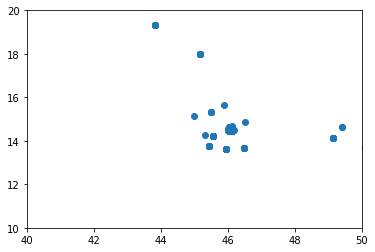

In [48]:
plt.scatter(df['latitude'],df['longitude'], label='Position')
axes = plt.gca()
axes.set_xlim([40,50])
axes.set_ylim([10,20])

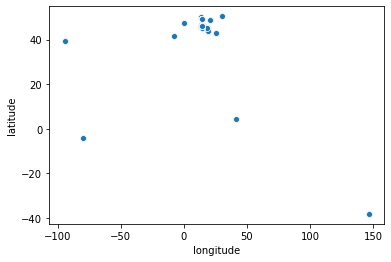

In [49]:
sns.scatterplot(df['longitude'], df['latitude'])

In [50]:
df['latitude'].describe()

count    1483.000000
mean       32.741207
std        24.049240
min       -38.197548
25%        39.212418
50%        46.000000
75%        46.060013
max        50.428212
Name: latitude, dtype: float64

In [51]:
df.count()

lokacija       1483
room_factor    1483
size           1483
price          1483
gradnja        1279
adaptacija      852
latitude       1483
longitude      1483
dtype: int64

In [52]:
df['latitude'].isnull().sum()

0

In order to use the location parameter accordingly, we must do something about it. Note that simply passing the latitude and longitude into the model would indicate that there is a direct correlation between one's latitude or longitude and the rent. We could use feature engineering and create a feature cross. A feature cross is a synthetic feature formed by multiplying (crossing) two or more features. Crossing combinations of features can provide predictive abilities beyond what those features can provide individually.

Tensorflow takes care of that by providing a feature_column. Check these links or other coursera content. 


https://www.tensorflow.org/api_docs/python/tf/feature_column/crossed_column

https://developers.google.com/machine-learning/crash-course/feature-crosses/video-lecture



But that's not what we'll be doing here. For this challenge I have chosen to use the KMeans clustering algorithm to sort the locations into clusters. The number of clusters is set to 10. This parameter could be higher, but since our dataset is not particularly large, I think sorting the locations into 10 clusters will do. KMeans provides enough compatibility, so we won't reinvent the wheel. 

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [53]:
X=df.loc[:,['latitude','longitude']]
X.shape

(1483, 2)

In [54]:
from sklearn.cluster import KMeans
clusters = 10
kmeans = KMeans(n_clusters=clusters)
kmeans.fit(X)

KMeans(n_clusters=10)

In [55]:
from folium.plugins import HeatMapWithTime
from branca.element import Figure
fig2=Figure(width=550,height=350)

ljubljana = folium.Map(location=center)
fig2.add_child(ljubljana)

folium.TileLayer('openstreetmap').add_to(ljubljana)
folium.TileLayer('Mapbox Control Room').add_to(ljubljana)
folium.TileLayer('Stamen Terrain').add_to(ljubljana)
folium.TileLayer('Stamen Toner').add_to(ljubljana)
folium.TileLayer('Stamen Water Color').add_to(ljubljana)
folium.TileLayer('cartodbpositron').add_to(ljubljana)
folium.TileLayer('cartodbdark_matter').add_to(ljubljana)
folium.LayerControl().add_to(ljubljana)


colors = ['#37AB65', '#3DF735', '#AD6D70', '#EC2504', '#8C0B90', '#C0E4FF', '#27B502', '#7C60A8', '#CF95D7', '#145JKH']
for _,row in X.iterrows():
    folium.Marker(location=[row["latitude"], row["longitude"]]).add_to(ljubljana)

dp.Report(dp.Plot(ljubljana), dp.Markdown("Ljubljana's apartments")).publish(name='Ljubljana', visibility = 'PUBLIC')
ljubljana.save('Ljubljana.html')

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/Timothy102/reports/ljubljana/


In [56]:
for i in range(0,len(kmeans.cluster_centers_)):
    folium.CircleMarker(
    location=kmeans.cluster_centers_[i],
    radius=50,
    popup="Cluster number {}".format(i),
    color=colors[i],
    fill=True,
    fill_color='#3186cc'
)

In [57]:
print(kmeans.labels_)

[0 0 0 ... 0 0 0]


Each number in the array kmeans.labels_ corresponds to the cluster the location belongs to and the location index in the pandas dataframe. I will be using these values in the model. 

In [58]:
print(type(kmeans.labels_))

<class 'numpy.ndarray'>


In [59]:
kmeans.cluster_centers_

array([[ 46.05597021,  14.48149148],
       [ -4.0528506 , -79.8053425 ],
       [-38.197548  , 146.5375551 ],
       [ 39.21241765, -94.53397894],
       [ 43.0820584 ,  25.6321312 ],
       [  4.2886254 ,  41.5168965 ],
       [ 44.62849583,  -3.75910989],
       [ 48.6921841 ,  21.0078226 ],
       [ 50.4282118 ,  30.5613074 ],
       [ 44.69124465,  18.47871821]])

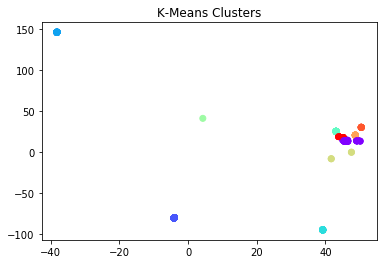

In [60]:
plt.scatter(X['latitude'],X['longitude'], c= kmeans.labels_, cmap='rainbow')
plt.title("K-Means Clusters")
plt.show()

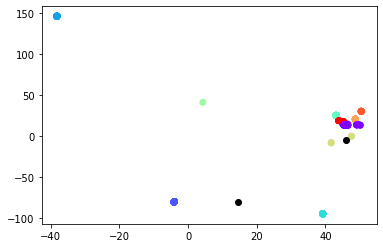

In [61]:
plt.scatter(X['latitude'], X['longitude'], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[0], kmeans.cluster_centers_[1], color='black')
plt.show()

In [62]:
ed = pd.DataFrame(kmeans.labels_)
ed.dropna()
ed.describe()

,0
count,1483.000000
mean,0.662171
std,1.516385
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,9.000000


In [63]:
df['labels'] = ed
df.head()

,lokacija,room_factor,size,price,gradnja,adaptacija,latitude,longitude,labels
0,"BEŽIGRAJSKI DVOR, PERIČEVA ULICA 1",3.0,"28,00 m2","400,00 €/mesec",1950.0,2007.0,46.000000,14.500000,0.0
1,BIZOVIK,5.0,"100,00 m2","750,00 €/mesec",1977.0,2020.0,46.035486,14.567925,0.0
2,BIZOVIK,7.0,"105,50 m2","1.500,00 €/mesec",2005.0,NaN,46.035486,14.567925,0.0
3,BRDO,1.0,"15,00 m2","250,00 €/mesec",1970.0,2003.0,45.449571,13.759716,0.0
4,BRDO,1.0,"15,00 m2","200,00 €/mesec",2002.0,2020.0,45.449571,13.759716,0.0


In [64]:
df.reset_index()
print(great_circle(center, (df.at[150,'latitude'], df.at[150,'longitude'])))

1.2113615767197619 km


In [65]:
df.drop(['longitude','lokacija','latitude'], inplace=True, axis=1)
df.head()
#'lokacija', 'latitude', 'labels',

,room_factor,size,price,gradnja,adaptacija,labels
0,3.0,"28,00 m2","400,00 €/mesec",1950.0,2007.0,0.0
1,5.0,"100,00 m2","750,00 €/mesec",1977.0,2020.0,0.0
2,7.0,"105,50 m2","1.500,00 €/mesec",2005.0,NaN,0.0
3,1.0,"15,00 m2","250,00 €/mesec",1970.0,2003.0,0.0
4,1.0,"15,00 m2","200,00 €/mesec",2002.0,2020.0,0.0


Let's drop unnecessary columns right away. We used the location to convert the location description into a geopy location, used a tuple of corresponding to each datapoint to the K-Means clustering and have eventually written the labels to the pandas dataframe. We won't be needing any of the three columns. 

In [66]:
df.dtypes

room_factor    float64
size            object
price           object
gradnja        float64
adaptacija     float64
labels         float64
dtype: object

## Size and price preprocessing

Again, size and price are string containing the values and units. First we will strip the columns of all data so we can transform them into numerical columns.

In [67]:
df['size'] = df['size'].str.strip(' m2')
df['price'] =df['price'].str.strip(' €/mesec')

df['size'] = df['size'].str.replace(',','.')

df['price'] = df['price'].str.replace('.','')
df['price'] = df['price'].str.replace(',00','')
df['price'] = df['price'].str.replace(' €/m2','')

df.head()

,room_factor,size,price,gradnja,adaptacija,labels
0,3.0,8.00,400,1950.0,2007.0,0.0
1,5.0,100.00,750,1977.0,2020.0,0.0
2,7.0,105.50,1500,2005.0,NaN,0.0
3,1.0,15.00,250,1970.0,2003.0,0.0
4,1.0,15.00,200,2002.0,2020.0,0.0


In [68]:
len(df['size'].unique())

425

In [69]:
index = df[ df['price'] == "70 €/dan" ].index 
df.drop(index, inplace =True)

In [70]:
df['size'] = pd.to_numeric(df['size'])
df['price'] = pd.to_numeric(df['price'])

df.head()

,room_factor,size,price,gradnja,adaptacija,labels
0,3.0,8.0,400,1950.0,2007.0,0.0
1,5.0,100.0,750,1977.0,2020.0,0.0
2,7.0,105.5,1500,2005.0,NaN,0.0
3,1.0,15.0,250,1970.0,2003.0,0.0
4,1.0,15.0,200,2002.0,2020.0,0.0


In [71]:
df.dtypes

room_factor    float64
size           float64
price            int64
gradnja        float64
adaptacija     float64
labels         float64
dtype: object

## Gradnja in adaptacija

In [72]:
df.isnull().sum()

room_factor      0
size             0
price            0
gradnja        204
adaptacija     630
labels           4
dtype: int64

We will be padding the null values using pandas' fillna method, so data isn't lost.

In [73]:
gradnja_median = df['gradnja'].median()
adapt_median = df['adaptacija'].median()

gradnja_median, adapt_median

(1977.0, 2017.0)

In [74]:
df = df.assign(perSquaredMeter = lambda x: (x['price'] /x['size'])) 
df = df.sort_values(by='adaptacija', ascending=False)
df['adaptacija'].fillna(method='pad',axis=0, inplace=True)
df = df.sort_values(by='gradnja', ascending=False)
df['gradnja'].fillna(method='pad',axis=0, inplace=True)

df.head()

,room_factor,size,price,gradnja,adaptacija,labels,perSquaredMeter
1155,3.5,39.68,650,2020.0,1954.0,0.0,16.381048
1405,2.0,5.00,420,2020.0,1954.0,0.0,84.000000
16,2.0,44.00,600,2020.0,1954.0,0.0,13.636364
716,3.0,38.50,510,2020.0,1954.0,0.0,13.246753
108,4.5,43.00,800,2020.0,1954.0,0.0,18.604651


In [75]:
df['size'] = df['size'].apply(lambda x : round(x,1))

df['gradnja'] = df['gradnja'].astype('int')
df['adaptacija'] = df['adaptacija'].astype('int')
df['size'] = df['size'].astype('int')

df['perSquaredMeter'] = df['perSquaredMeter'].apply(lambda x : round(x,1))
df['adaptacija'] = df['adaptacija'].apply(lambda x: 2020 - x)
df['gradnja'] = df['gradnja'].apply(lambda x: 2020 - x)


df.head()

,room_factor,size,price,gradnja,adaptacija,labels,perSquaredMeter
1155,3.5,39,650,0,66,0.0,16.4
1405,2.0,5,420,0,66,0.0,84.0
16,2.0,44,600,0,66,0.0,13.6
716,3.0,38,510,0,66,0.0,13.2
108,4.5,43,800,0,66,0.0,18.6


In [76]:
df.isnull().sum()

room_factor        0
size               0
price              0
gradnja            0
adaptacija         0
labels             4
perSquaredMeter    0
dtype: int64

In [77]:
def truncate(x, decimals):
    return (x*10**decimals)/10*decimals

In [78]:
from sklearn.preprocessing import MinMaxScaler
room_max = df['room_factor'].max()
size_max = df['size'].max()
gradnja_max = df['gradnja'].max()
adaptacija_max = df['adaptacija'].max()


gradnja = df['gradnja'].to_numpy().reshape((-1,1))
adaptacija = df['adaptacija'].to_numpy().reshape((-1,1))

min_max_scaler = MinMaxScaler()
df['gradnja'] = min_max_scaler.fit_transform(gradnja)
df['adaptacija'] = min_max_scaler.fit_transform(adaptacija)
df['gradnja'] = df['gradnja'].apply(lambda x: round(x, 2))
df['adaptacija'] = df['adaptacija'].apply(lambda x: round(x, 2))

df.head()


,room_factor,size,price,gradnja,adaptacija,labels,perSquaredMeter
1155,3.5,39,650,0.0,1.0,0.0,16.4
1405,2.0,5,420,0.0,1.0,0.0,84.0
16,2.0,44,600,0.0,1.0,0.0,13.6
716,3.0,38,510,0.0,1.0,0.0,13.2
108,4.5,43,800,0.0,1.0,0.0,18.6


In [79]:
df['gradnja'].unique()

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.34,
       0.35, 0.38, 0.39, 0.43, 0.47, 0.48, 0.51, 0.52, 0.57, 0.66, 0.74,
       0.82, 0.83, 0.89, 0.91, 0.92, 1.  ])

In [80]:
df['adaptacija'].max()

1.0

## Correlation

Next up is data visualisation in attempt to see how categories correlate to each other. 

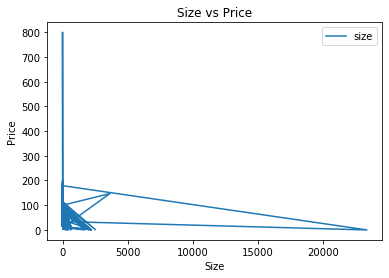

In [81]:
df.plot(x='perSquaredMeter',y='size')
plt.xlabel("Size")
plt.ylabel('Price')
plt.legend()
plt.title("Size vs Price")
plt.show()

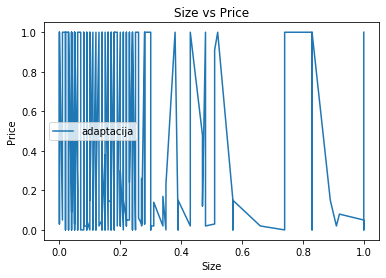

In [82]:
df.plot(x='gradnja',y='adaptacija')
plt.xlabel("Size")
plt.ylabel('Price')
plt.legend()
plt.title("Size vs Price")
plt.show()

In [83]:
corrmap = df.corr()
corrmap

,room_factor,size,price,gradnja,adaptacija,labels,perSquaredMeter
room_factor,1.000000,0.723138,0.083902,-0.160947,0.071576,-0.021241,0.067171
size,0.723138,1.000000,0.076155,-0.121242,0.076814,-0.015764,-0.064818
price,0.083902,0.076155,1.000000,-0.005261,-0.019315,-0.012872,0.159658
gradnja,-0.160947,-0.121242,-0.005261,1.000000,-0.415210,-0.016026,-0.003888
adaptacija,0.071576,0.076814,-0.019315,-0.415210,1.000000,0.004091,0.017308
labels,-0.021241,-0.015764,-0.012872,-0.016026,0.004091,1.000000,-0.018188
perSquaredMeter,0.067171,-0.064818,0.159658,-0.003888,0.017308,-0.018188,1.000000


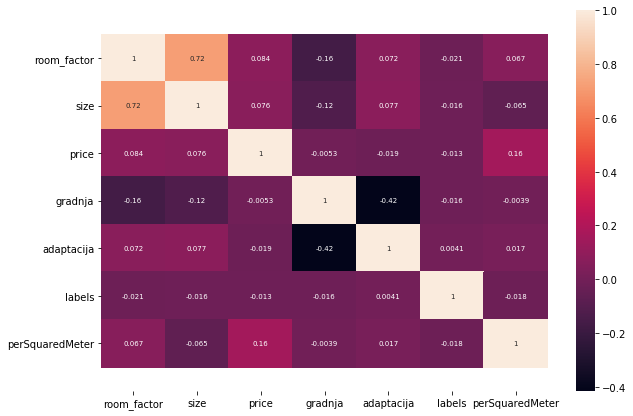

In [84]:
fig, ax = plt.subplots(figsize = (10, 7))
sns.heatmap(corrmap, annot = True, annot_kws = {'size': 7})
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-.5)
plt. show()

In [85]:
def getCorrelatedFeature(corrdata, threshold):
    feature = []
    value = []
    for i, index in enumerate(corrdata.index):
        if abs(corrdata[index]) > threshold:
            feature.append(index)
            value.append(corrdata[index])
    df = pd.DataFrame(data = value, index=feature, columns=['corr value'])
    return df

In [86]:
corr_df = getCorrelatedFeature(corrmap['labels'],0.5)
corr_df

,corr value
labels,1.0


In statistics, the Pearson correlation coefficient (PCC, pronounced /ˈpɪərsən/), also referred to as Pearson's r, the Pearson product-moment correlation coefficient (PPMCC), or the bivariate correlation,is a statistic that measures linear correlation between two variables X and Y. It has a value between +1 and −1. A value of +1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

In [87]:
from scipy.stats import pearsonr
stat, p = pearsonr(df.room_factor, df.price)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.084, p=0.001
Probably dependent


In [88]:
stat, p = pearsonr(df.price, df.price)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=1.000, p=0.000
Probably dependent


## Getting ready for model training

In [89]:
Y = df['price']
df.drop(['perSquaredMeter','price'], inplace=True, axis=1)
df.tail()

,room_factor,size,gradnja,adaptacija,labels
84,1.0,15,1.0,0.35,0.0
1348,5.0,103,1.0,0.36,1.0
33,1.0,3,1.0,0.53,0.0
1154,4.0,45,1.0,0.67,0.0
1217,2.0,5,1.0,1.00,0.0


In [90]:
df['labels'].fillna(method='pad',axis=0, inplace=True)
df.isnull().sum()

room_factor    0
size           0
gradnja        0
adaptacija     0
labels         0
dtype: int64

In [91]:
df.shape, Y.shape

((1482, 5), (1482,))

In [92]:
from sklearn.model_selection import train_test_split
split_ratio = 0.1

x_train, x_test, y_train, y_test = train_test_split(df, Y, test_size=split_ratio, shuffle=True)
x_train.shape,y_train.shape

((1333, 5), (1333,))

## Model training

In [93]:
!ls logs/hparam_tuning

run-0


In [96]:
!rm -rf ./logs/
!rm -rf checkpoint
!ls 

 appdata.json	      Ljubljana.ipynb		   log.txt	  scraper.py
 dp-cache	     '\logs\fit\20201030-120447'   lr.png
 generated_file.csv  '\logs\fit\20201030-120459'   nepremicnine
 Ljubljana.html      '\logs\fit\20201030-153155'   README.md


In [97]:
%load_ext tensorboard

Tuning machine learning hyperparameters is a tedious yet crucial task, as the performance of an algorithm can be highly dependent on the choice of hyperparameters. Manual tuning takes time away from important steps of the machine learning pipeline like feature engineering and interpreting results. Grid and random search are hands-off, but require long run times because they waste time evaluating unpromising areas of the search space. Increasingly, hyperparameter tuning is done by automated methods that aim to find optimal hyperparameters in less time using an informed search with no manual effort necessary beyond the initial set-up.

In [98]:
from tensorboard.plugins.hparams import api as hp

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([8, 64]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
HP_LEARNING_RATE= hp.HParam('learning_rate', hp.Discrete([0.001, 0.0005, 0.0001]))
HP_OPTIMIZER=hp.HParam('optimizer', hp.Discrete(['adam', 'sgd', 'rmsprop']))

METRIC_ACCURACY = 'RootMeanSquaredError'
log_dir ='\\logs\\fit\\' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
with tf.summary.create_file_writer(log_dir).as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT,  HP_OPTIMIZER, HP_LEARNING_RATE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Rmse')],
    )

In [99]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.losses import Huber

checkpoint_best = ModelCheckpoint('checkpoint', monitor='val_loss', save_freq='epoch',save_best_only=True)
early_stopper = EarlyStopping(monitor='val_loss', patience=25, mode='auto', min_delta = 0.0001)
tensorboard = TensorBoard(log_dir = log_dir, histogram_freq=10, write_graph=True, write_images=False)
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=10, min_delta=0.001)

In [100]:
def create_model(hparams):
    model = tf.keras.Sequential([
        Dense(512,input_shape=[5]),
        Dense(128,activation='relu',kernel_regularizer=l1(1e-4)),
        BatchNormalization(),
        Dense(128,activation='relu'),
        Dropout(hparams[HP_DROPOUT]),
        Dense(64, activation='relu'),
        Dropout(hparams[HP_DROPOUT]),
        Dense(hparams[HP_NUM_UNITS], activation='relu'),
        Dense(16,activation='relu'),    
        Dense(1)
    ], name = 'rentals_model')
    optimizer = hparams[HP_OPTIMIZER]
    learning_rate = hparams[HP_LEARNING_RATE]
    
    if optimizer == "adam":
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer=='rmsprop':
        optimizer = tf.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Not an optimizer name: %r" % (optimizer_name,))
    
    model.compile(optimizer = optimizer, loss = Huber(), metrics=['RootMeanSquaredError'])
    return model
def train_and_evaluate(model, hparams):
    
    hp_tuning = hp.KerasCallback(log_dir, hparams),
    cbs = [tensorboard, hp_tuning]
    
    history = model.fit(x_train, y_train,validation_split=0.1,epochs=100, shuffle = True, callbacks = cbs,verbose=2)
    _, rmse = model.evaluate(x_test,y_test)
    return rmse, history

In [101]:
model = create_model(hparams)
model.summary()

NameError: name 'hparams' is not defined

In [102]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)
        model = create_model(hparams)
        accuracy, history = train_and_evaluate(model, hparams)
        #accuracy= tf.reshape(tf.convert_to_tensor(accuracy), []).numpy()
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
    return history

In [103]:
session_num = 0
for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            for learning_rate in HP_LEARNING_RATE.domain.values:
                hparams = {
                  HP_NUM_UNITS: num_units,
                  HP_DROPOUT: dropout_rate,
                  HP_OPTIMIZER: optimizer,
                  HP_LEARNING_RATE: learning_rate,
              }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            history = run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1

--- Starting trial: run-0
{'num_units': 8, 'dropout': 0.1, 'optimizer': 'adam', 'learning_rate': 0.001}
Epoch 1/100
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
38/38 - 0s - loss: 1240.8668 - root_mean_squared_error: 15481.6484 - val_loss: 714.4104 - val_root_mean_squared_error: 872.1953
Epoch 2/100
38/38 - 0s - loss: 1123.0844 - root_mean_squared_error: 15471.5293 - val_loss: 311.0982 - val_root_mean_squared_error: 446.6107
Epoch 3/100
38/38 - 0s - loss: 792.6902 - root_mean_squared_error: 15427.1543 - val_loss: 233.5913 - val_root_mean_squared_error: 338.6593
Epoch 4/100
38/38 - 0s - loss: 706.9884 - root_mean_squared_error: 15412.7139 - val_loss: 346.8250 - val_root_mean_squared_error: 504.2355
Epoch 5/100
38/38 - 0s - loss: 675.2477 - root_mean_squared_error: 15411.0352 - val_loss: 229.2484 - val_root_mean_squared_error: 348.4391
Epoch 6/100
38/38 - 0s - loss: 667.3259 - root_mean_squared_error: 15398.9131 - val_loss: 220.5448 - val_root_mean_squared_erro

Epoch 56/100
38/38 - 0s - loss: 645.2761 - root_mean_squared_error: 15410.0410 - val_loss: 202.4975 - val_root_mean_squared_error: 308.6280
Epoch 57/100
38/38 - 0s - loss: 647.3605 - root_mean_squared_error: 15408.1348 - val_loss: 298.1481 - val_root_mean_squared_error: 384.9669
Epoch 58/100
38/38 - 0s - loss: 636.9654 - root_mean_squared_error: 15399.0225 - val_loss: 200.4256 - val_root_mean_squared_error: 308.0549
Epoch 59/100
38/38 - 0s - loss: 640.2505 - root_mean_squared_error: 15410.8330 - val_loss: 193.7442 - val_root_mean_squared_error: 304.7025
Epoch 60/100
38/38 - 0s - loss: 632.3837 - root_mean_squared_error: 15399.6543 - val_loss: 200.3724 - val_root_mean_squared_error: 306.3368
Epoch 61/100
38/38 - 0s - loss: 646.5946 - root_mean_squared_error: 15409.0625 - val_loss: 191.0752 - val_root_mean_squared_error: 303.4079
Epoch 62/100
38/38 - 0s - loss: 638.2044 - root_mean_squared_error: 15406.1553 - val_loss: 194.6052 - val_root_mean_squared_error: 304.7047
Epoch 63/100
38/38 -

Epoch 12/100
38/38 - 0s - loss: 649.9427 - root_mean_squared_error: 15392.3271 - val_loss: 1177.3453 - val_root_mean_squared_error: 1428.2133
Epoch 13/100
38/38 - 0s - loss: 646.6760 - root_mean_squared_error: 15414.1650 - val_loss: 392.4362 - val_root_mean_squared_error: 543.8524
Epoch 14/100
38/38 - 0s - loss: 651.2773 - root_mean_squared_error: 15397.2109 - val_loss: 638.5931 - val_root_mean_squared_error: 799.0172
Epoch 15/100
38/38 - 0s - loss: 645.7887 - root_mean_squared_error: 15415.5410 - val_loss: 943.8955 - val_root_mean_squared_error: 1167.7826
Epoch 16/100
38/38 - 0s - loss: 648.0562 - root_mean_squared_error: 15400.9951 - val_loss: 561.8303 - val_root_mean_squared_error: 744.4434
Epoch 17/100
38/38 - 0s - loss: 652.5449 - root_mean_squared_error: 15403.9766 - val_loss: 231.8466 - val_root_mean_squared_error: 323.0145
Epoch 18/100
38/38 - 0s - loss: 645.5273 - root_mean_squared_error: 15408.2207 - val_loss: 1009.4323 - val_root_mean_squared_error: 1246.1187
Epoch 19/100
38

Epoch 71/100
38/38 - 0s - loss: 642.1571 - root_mean_squared_error: 15396.5840 - val_loss: 189.3777 - val_root_mean_squared_error: 302.9044
Epoch 72/100
38/38 - 0s - loss: 641.0977 - root_mean_squared_error: 15406.1045 - val_loss: 197.2931 - val_root_mean_squared_error: 306.2374
Epoch 73/100
38/38 - 0s - loss: 640.3999 - root_mean_squared_error: 15403.8916 - val_loss: 241.0632 - val_root_mean_squared_error: 364.2734
Epoch 74/100
38/38 - 0s - loss: 644.5286 - root_mean_squared_error: 15414.2861 - val_loss: 213.1420 - val_root_mean_squared_error: 321.9620
Epoch 75/100
38/38 - 0s - loss: 648.8937 - root_mean_squared_error: 15407.9004 - val_loss: 212.2545 - val_root_mean_squared_error: 315.5141
Epoch 76/100
38/38 - 0s - loss: 637.7834 - root_mean_squared_error: 15404.3291 - val_loss: 214.8688 - val_root_mean_squared_error: 332.6538
Epoch 77/100
38/38 - 0s - loss: 643.3889 - root_mean_squared_error: 15404.2012 - val_loss: 199.2458 - val_root_mean_squared_error: 309.5010
Epoch 78/100
38/38 -

Epoch 27/100
38/38 - 0s - loss: 682.9744 - root_mean_squared_error: 15414.1016 - val_loss: 193.9383 - val_root_mean_squared_error: 309.6012
Epoch 28/100
38/38 - 0s - loss: 676.2313 - root_mean_squared_error: 15405.3623 - val_loss: 240.0804 - val_root_mean_squared_error: 339.5511
Epoch 29/100
38/38 - 0s - loss: 680.6950 - root_mean_squared_error: 15397.7725 - val_loss: 272.1177 - val_root_mean_squared_error: 421.2735
Epoch 30/100
38/38 - 0s - loss: 681.9876 - root_mean_squared_error: 15413.0029 - val_loss: 218.8947 - val_root_mean_squared_error: 329.2071
Epoch 31/100
38/38 - 0s - loss: 682.5873 - root_mean_squared_error: 15410.6113 - val_loss: 211.1608 - val_root_mean_squared_error: 318.8614
Epoch 32/100
38/38 - 0s - loss: 690.5706 - root_mean_squared_error: 15422.5811 - val_loss: 229.5393 - val_root_mean_squared_error: 364.2671
Epoch 33/100
38/38 - 0s - loss: 683.9718 - root_mean_squared_error: 15416.6631 - val_loss: 227.7986 - val_root_mean_squared_error: 331.9479
Epoch 34/100
38/38 -

Epoch 86/100
38/38 - 0s - loss: 665.7275 - root_mean_squared_error: 15411.1768 - val_loss: 225.6740 - val_root_mean_squared_error: 368.3409
Epoch 87/100
38/38 - 0s - loss: 671.0298 - root_mean_squared_error: 15411.1602 - val_loss: 263.8090 - val_root_mean_squared_error: 349.9871
Epoch 88/100
38/38 - 0s - loss: 670.8885 - root_mean_squared_error: 15412.2256 - val_loss: 228.3525 - val_root_mean_squared_error: 333.2725
Epoch 89/100
38/38 - 0s - loss: 666.3996 - root_mean_squared_error: 15417.8643 - val_loss: 237.8631 - val_root_mean_squared_error: 356.7476
Epoch 90/100
38/38 - 0s - loss: 677.8026 - root_mean_squared_error: 15399.9375 - val_loss: 194.4778 - val_root_mean_squared_error: 312.2466
Epoch 91/100
38/38 - 0s - loss: 667.0974 - root_mean_squared_error: 15407.1436 - val_loss: 332.9296 - val_root_mean_squared_error: 475.8009
Epoch 92/100
38/38 - 0s - loss: 688.5093 - root_mean_squared_error: 15406.4658 - val_loss: 235.6272 - val_root_mean_squared_error: 359.0060
Epoch 93/100
38/38 -

Epoch 42/100
38/38 - 0s - loss: 655.0778 - root_mean_squared_error: 15403.6172 - val_loss: 190.0724 - val_root_mean_squared_error: 309.7677
Epoch 43/100
38/38 - 0s - loss: 660.9946 - root_mean_squared_error: 15404.9580 - val_loss: 196.1051 - val_root_mean_squared_error: 328.1620
Epoch 44/100
38/38 - 0s - loss: 648.7532 - root_mean_squared_error: 15406.9619 - val_loss: 190.2852 - val_root_mean_squared_error: 301.1319
Epoch 45/100
38/38 - 0s - loss: 653.3632 - root_mean_squared_error: 15400.2510 - val_loss: 200.9294 - val_root_mean_squared_error: 312.7142
Epoch 46/100
38/38 - 0s - loss: 655.0206 - root_mean_squared_error: 15417.6387 - val_loss: 186.6674 - val_root_mean_squared_error: 306.7102
Epoch 47/100
38/38 - 0s - loss: 657.9946 - root_mean_squared_error: 15412.1455 - val_loss: 213.8734 - val_root_mean_squared_error: 347.8959
Epoch 48/100
38/38 - 0s - loss: 658.0444 - root_mean_squared_error: 15417.8213 - val_loss: 195.6985 - val_root_mean_squared_error: 325.7917
Epoch 49/100
38/38 -

5/5 [==============================] - 0s 2ms/step - loss: 169.3775 - root_mean_squared_error: 561.2056
--- Starting trial: run-4
{'num_units': 8, 'dropout': 0.3, 'optimizer': 'rmsprop', 'learning_rate': 0.001}
Epoch 1/100
38/38 - 0s - loss: 1233.6654 - root_mean_squared_error: 15482.0303 - val_loss: 681.0840 - val_root_mean_squared_error: 835.5331
Epoch 2/100
38/38 - 0s - loss: 1100.4559 - root_mean_squared_error: 15462.9131 - val_loss: 233.3280 - val_root_mean_squared_error: 347.8600
Epoch 3/100
38/38 - 0s - loss: 820.0665 - root_mean_squared_error: 15413.1680 - val_loss: 360.5781 - val_root_mean_squared_error: 452.8747
Epoch 4/100
38/38 - 0s - loss: 711.7168 - root_mean_squared_error: 15413.9961 - val_loss: 554.9343 - val_root_mean_squared_error: 705.5723
Epoch 5/100
38/38 - 0s - loss: 679.6887 - root_mean_squared_error: 15401.9736 - val_loss: 641.5493 - val_root_mean_squared_error: 839.2934
Epoch 6/100
38/38 - 0s - loss: 665.1083 - root_mean_squared_error: 15404.0889 - val_loss: 56

Epoch 57/100
38/38 - 0s - loss: 650.7968 - root_mean_squared_error: 15410.7266 - val_loss: 275.2529 - val_root_mean_squared_error: 416.8408
Epoch 58/100
38/38 - 0s - loss: 652.1783 - root_mean_squared_error: 15414.4229 - val_loss: 194.1764 - val_root_mean_squared_error: 306.5702
Epoch 59/100
38/38 - 0s - loss: 653.4441 - root_mean_squared_error: 15398.5391 - val_loss: 198.1400 - val_root_mean_squared_error: 305.0822
Epoch 60/100
38/38 - 0s - loss: 651.8387 - root_mean_squared_error: 15407.6836 - val_loss: 189.4854 - val_root_mean_squared_error: 306.8384
Epoch 61/100
38/38 - 0s - loss: 648.7626 - root_mean_squared_error: 15405.7080 - val_loss: 195.8392 - val_root_mean_squared_error: 307.9428
Epoch 62/100
38/38 - 0s - loss: 659.7648 - root_mean_squared_error: 15408.7314 - val_loss: 201.5157 - val_root_mean_squared_error: 328.6410
Epoch 63/100
38/38 - 0s - loss: 652.6505 - root_mean_squared_error: 15412.6621 - val_loss: 208.5750 - val_root_mean_squared_error: 314.1491
Epoch 64/100
38/38 -

Epoch 13/100
38/38 - 0s - loss: 707.4312 - root_mean_squared_error: 15393.3945 - val_loss: 376.0571 - val_root_mean_squared_error: 499.2686
Epoch 14/100
38/38 - 0s - loss: 706.3463 - root_mean_squared_error: 15414.8672 - val_loss: 266.6235 - val_root_mean_squared_error: 375.9752
Epoch 15/100
38/38 - 0s - loss: 696.1017 - root_mean_squared_error: 15418.2666 - val_loss: 364.2781 - val_root_mean_squared_error: 480.4720
Epoch 16/100
38/38 - 0s - loss: 702.6772 - root_mean_squared_error: 15426.8535 - val_loss: 348.5056 - val_root_mean_squared_error: 467.3736
Epoch 17/100
38/38 - 0s - loss: 684.3058 - root_mean_squared_error: 15419.2637 - val_loss: 315.9364 - val_root_mean_squared_error: 443.3967
Epoch 18/100
38/38 - 0s - loss: 704.0173 - root_mean_squared_error: 15397.5400 - val_loss: 289.8047 - val_root_mean_squared_error: 424.5579
Epoch 19/100
38/38 - 0s - loss: 690.9257 - root_mean_squared_error: 15426.5869 - val_loss: 208.6843 - val_root_mean_squared_error: 320.3980
Epoch 20/100
38/38 -

Epoch 72/100
38/38 - 0s - loss: 690.5745 - root_mean_squared_error: 15392.5586 - val_loss: 220.3646 - val_root_mean_squared_error: 353.3462
Epoch 73/100
38/38 - 0s - loss: 675.4246 - root_mean_squared_error: 15416.7314 - val_loss: 236.3523 - val_root_mean_squared_error: 368.3410
Epoch 74/100
38/38 - 0s - loss: 681.0091 - root_mean_squared_error: 15388.1719 - val_loss: 209.3874 - val_root_mean_squared_error: 336.5522
Epoch 75/100
38/38 - 0s - loss: 682.2819 - root_mean_squared_error: 15401.9648 - val_loss: 312.4204 - val_root_mean_squared_error: 451.2943
Epoch 76/100
38/38 - 0s - loss: 679.8540 - root_mean_squared_error: 15411.5508 - val_loss: 203.1421 - val_root_mean_squared_error: 320.4879
Epoch 77/100
38/38 - 0s - loss: 691.2766 - root_mean_squared_error: 15412.0273 - val_loss: 340.4583 - val_root_mean_squared_error: 448.2654
Epoch 78/100
38/38 - 0s - loss: 689.1567 - root_mean_squared_error: 15416.7412 - val_loss: 218.9800 - val_root_mean_squared_error: 323.9204
Epoch 79/100
38/38 -

Epoch 28/100
38/38 - 0s - loss: 645.2369 - root_mean_squared_error: 15400.5908 - val_loss: 188.4933 - val_root_mean_squared_error: 305.5113
Epoch 29/100
38/38 - 0s - loss: 646.7859 - root_mean_squared_error: 15399.7529 - val_loss: 236.1365 - val_root_mean_squared_error: 372.8182
Epoch 30/100
38/38 - 0s - loss: 641.8159 - root_mean_squared_error: 15407.0029 - val_loss: 223.0288 - val_root_mean_squared_error: 333.1145
Epoch 31/100
38/38 - 0s - loss: 642.8256 - root_mean_squared_error: 15401.0312 - val_loss: 189.8503 - val_root_mean_squared_error: 303.3035
Epoch 32/100
38/38 - 0s - loss: 644.7921 - root_mean_squared_error: 15411.9434 - val_loss: 192.5091 - val_root_mean_squared_error: 315.3734
Epoch 33/100
38/38 - 0s - loss: 648.7480 - root_mean_squared_error: 15406.0205 - val_loss: 205.1399 - val_root_mean_squared_error: 307.9178
Epoch 34/100
38/38 - 0s - loss: 642.2026 - root_mean_squared_error: 15409.9072 - val_loss: 189.7436 - val_root_mean_squared_error: 301.8252
Epoch 35/100
38/38 -

Epoch 87/100
38/38 - 0s - loss: 640.2040 - root_mean_squared_error: 15407.1045 - val_loss: 255.9185 - val_root_mean_squared_error: 377.4543
Epoch 88/100
38/38 - 0s - loss: 639.4132 - root_mean_squared_error: 15411.4541 - val_loss: 197.6588 - val_root_mean_squared_error: 305.6362
Epoch 89/100
38/38 - 0s - loss: 644.0598 - root_mean_squared_error: 15405.1074 - val_loss: 275.8399 - val_root_mean_squared_error: 410.8639
Epoch 90/100
38/38 - 0s - loss: 640.3159 - root_mean_squared_error: 15402.4121 - val_loss: 201.1072 - val_root_mean_squared_error: 308.2497
Epoch 91/100
38/38 - 0s - loss: 637.8346 - root_mean_squared_error: 15403.9873 - val_loss: 197.7660 - val_root_mean_squared_error: 308.5440
Epoch 92/100
38/38 - 0s - loss: 644.2212 - root_mean_squared_error: 15398.4189 - val_loss: 186.2025 - val_root_mean_squared_error: 302.1913
Epoch 93/100
38/38 - 0s - loss: 633.8846 - root_mean_squared_error: 15412.7256 - val_loss: 200.2820 - val_root_mean_squared_error: 315.2908
Epoch 94/100
38/38 -

Epoch 43/100
38/38 - 0s - loss: 643.7009 - root_mean_squared_error: 15408.0518 - val_loss: 238.0924 - val_root_mean_squared_error: 348.1122
Epoch 44/100
38/38 - 0s - loss: 655.9736 - root_mean_squared_error: 15401.0029 - val_loss: 191.7194 - val_root_mean_squared_error: 312.5893
Epoch 45/100
38/38 - 0s - loss: 647.6417 - root_mean_squared_error: 15410.1357 - val_loss: 207.0073 - val_root_mean_squared_error: 335.6161
Epoch 46/100
38/38 - 0s - loss: 649.1331 - root_mean_squared_error: 15390.9004 - val_loss: 197.4468 - val_root_mean_squared_error: 308.6755
Epoch 47/100
38/38 - 0s - loss: 646.9788 - root_mean_squared_error: 15402.4854 - val_loss: 241.6222 - val_root_mean_squared_error: 359.6771
Epoch 48/100
38/38 - 0s - loss: 654.6070 - root_mean_squared_error: 15417.6152 - val_loss: 442.3789 - val_root_mean_squared_error: 598.3206
Epoch 49/100
38/38 - 0s - loss: 644.8994 - root_mean_squared_error: 15389.2432 - val_loss: 414.6554 - val_root_mean_squared_error: 548.0297
Epoch 50/100
38/38 -

5/5 [==============================] - 0s 3ms/step - loss: 189.0286 - root_mean_squared_error: 788.2008
--- Starting trial: run-8
{'num_units': 64, 'dropout': 0.1, 'optimizer': 'sgd', 'learning_rate': 0.001}
Epoch 1/100
38/38 - 0s - loss: 1246.0096 - root_mean_squared_error: 15482.7529 - val_loss: 764.1132 - val_root_mean_squared_error: 929.4774
Epoch 2/100
38/38 - 0s - loss: 1245.1091 - root_mean_squared_error: 15482.5498 - val_loss: 763.1028 - val_root_mean_squared_error: 928.3419
Epoch 3/100
38/38 - 0s - loss: 1243.5094 - root_mean_squared_error: 15482.3701 - val_loss: 760.3405 - val_root_mean_squared_error: 925.3024
Epoch 4/100
38/38 - 0s - loss: 1239.1632 - root_mean_squared_error: 15481.4268 - val_loss: 749.1246 - val_root_mean_squared_error: 912.8477
Epoch 5/100
38/38 - 0s - loss: 1199.8190 - root_mean_squared_error: 15476.7539 - val_loss: 369.5854 - val_root_mean_squared_error: 479.0506
Epoch 6/100
38/38 - 0s - loss: 851.5504 - root_mean_squared_error: 15405.8701 - val_loss: 26

Epoch 57/100
38/38 - 0s - loss: 682.7802 - root_mean_squared_error: 15406.9199 - val_loss: 225.2824 - val_root_mean_squared_error: 344.8901
Epoch 58/100
38/38 - 0s - loss: 682.2047 - root_mean_squared_error: 15423.7236 - val_loss: 318.8207 - val_root_mean_squared_error: 467.4790
Epoch 59/100
38/38 - 0s - loss: 664.6918 - root_mean_squared_error: 15404.8125 - val_loss: 313.4966 - val_root_mean_squared_error: 426.1246
Epoch 60/100
38/38 - 0s - loss: 667.3866 - root_mean_squared_error: 15396.7227 - val_loss: 235.7487 - val_root_mean_squared_error: 371.3526
Epoch 61/100
38/38 - 0s - loss: 675.6874 - root_mean_squared_error: 15420.4600 - val_loss: 202.8671 - val_root_mean_squared_error: 331.3798
Epoch 62/100
38/38 - 0s - loss: 676.0134 - root_mean_squared_error: 15405.1641 - val_loss: 191.6987 - val_root_mean_squared_error: 308.6530
Epoch 63/100
38/38 - 0s - loss: 679.6384 - root_mean_squared_error: 15407.0840 - val_loss: 206.0773 - val_root_mean_squared_error: 318.9455
Epoch 64/100
38/38 -

Epoch 13/100
38/38 - 0s - loss: 666.3448 - root_mean_squared_error: 15405.3174 - val_loss: 237.8367 - val_root_mean_squared_error: 370.9550
Epoch 14/100
38/38 - 0s - loss: 664.9484 - root_mean_squared_error: 15415.0615 - val_loss: 265.0472 - val_root_mean_squared_error: 405.1648
Epoch 15/100
38/38 - 0s - loss: 656.9266 - root_mean_squared_error: 15399.9307 - val_loss: 191.2147 - val_root_mean_squared_error: 306.6642
Epoch 16/100
38/38 - 0s - loss: 656.6034 - root_mean_squared_error: 15405.4570 - val_loss: 226.4655 - val_root_mean_squared_error: 328.0396
Epoch 17/100
38/38 - 0s - loss: 657.2114 - root_mean_squared_error: 15410.3125 - val_loss: 187.9660 - val_root_mean_squared_error: 308.1107
Epoch 18/100
38/38 - 0s - loss: 661.1003 - root_mean_squared_error: 15416.4668 - val_loss: 269.7123 - val_root_mean_squared_error: 386.8383
Epoch 19/100
38/38 - 0s - loss: 654.9432 - root_mean_squared_error: 15410.4443 - val_loss: 266.0232 - val_root_mean_squared_error: 368.8950
Epoch 20/100
38/38 -

Epoch 72/100
38/38 - 0s - loss: 648.2622 - root_mean_squared_error: 15404.7305 - val_loss: 193.0713 - val_root_mean_squared_error: 311.1390
Epoch 73/100
38/38 - 0s - loss: 653.5484 - root_mean_squared_error: 15405.0186 - val_loss: 187.4572 - val_root_mean_squared_error: 300.7759
Epoch 74/100
38/38 - 0s - loss: 651.2458 - root_mean_squared_error: 15403.6699 - val_loss: 210.0417 - val_root_mean_squared_error: 318.8443
Epoch 75/100
38/38 - 0s - loss: 656.8148 - root_mean_squared_error: 15414.5840 - val_loss: 191.6423 - val_root_mean_squared_error: 313.2254
Epoch 76/100
38/38 - 0s - loss: 658.8630 - root_mean_squared_error: 15395.5039 - val_loss: 222.1693 - val_root_mean_squared_error: 355.3096
Epoch 77/100
38/38 - 0s - loss: 658.6588 - root_mean_squared_error: 15392.7158 - val_loss: 213.6960 - val_root_mean_squared_error: 352.6905
Epoch 78/100
38/38 - 0s - loss: 654.3845 - root_mean_squared_error: 15419.6240 - val_loss: 247.6668 - val_root_mean_squared_error: 355.8013
Epoch 79/100
38/38 -

Epoch 28/100
38/38 - 0s - loss: 653.5013 - root_mean_squared_error: 15409.7998 - val_loss: 889.5170 - val_root_mean_squared_error: 1029.3757
Epoch 29/100
38/38 - 0s - loss: 665.5289 - root_mean_squared_error: 15407.9609 - val_loss: 607.2767 - val_root_mean_squared_error: 782.5516
Epoch 30/100
38/38 - 0s - loss: 656.4865 - root_mean_squared_error: 15385.9277 - val_loss: 195.9997 - val_root_mean_squared_error: 305.1763
Epoch 31/100
38/38 - 0s - loss: 655.9540 - root_mean_squared_error: 15414.1875 - val_loss: 297.3558 - val_root_mean_squared_error: 428.5663
Epoch 32/100
38/38 - 0s - loss: 649.0618 - root_mean_squared_error: 15401.9639 - val_loss: 197.3870 - val_root_mean_squared_error: 318.6087
Epoch 33/100
38/38 - 0s - loss: 659.4412 - root_mean_squared_error: 15402.8945 - val_loss: 908.4529 - val_root_mean_squared_error: 1137.2527
Epoch 34/100
38/38 - 0s - loss: 651.5575 - root_mean_squared_error: 15416.0381 - val_loss: 520.0254 - val_root_mean_squared_error: 647.2691
Epoch 35/100
38/38

Epoch 87/100
38/38 - 0s - loss: 659.1932 - root_mean_squared_error: 15426.2949 - val_loss: 191.2224 - val_root_mean_squared_error: 308.0502
Epoch 88/100
38/38 - 0s - loss: 661.8094 - root_mean_squared_error: 15402.2080 - val_loss: 191.8563 - val_root_mean_squared_error: 314.1164
Epoch 89/100
38/38 - 0s - loss: 658.1177 - root_mean_squared_error: 15412.2822 - val_loss: 203.3540 - val_root_mean_squared_error: 307.2350
Epoch 90/100
38/38 - 0s - loss: 668.7028 - root_mean_squared_error: 15401.9619 - val_loss: 241.1457 - val_root_mean_squared_error: 365.0648
Epoch 91/100
38/38 - 0s - loss: 663.1612 - root_mean_squared_error: 15412.1064 - val_loss: 190.6300 - val_root_mean_squared_error: 302.0848
Epoch 92/100
38/38 - 0s - loss: 662.4330 - root_mean_squared_error: 15393.8350 - val_loss: 255.1554 - val_root_mean_squared_error: 395.2856
Epoch 93/100
38/38 - 0s - loss: 668.4848 - root_mean_squared_error: 15416.9053 - val_loss: 236.0562 - val_root_mean_squared_error: 371.2403
Epoch 94/100
38/38 -

Epoch 43/100
38/38 - 0s - loss: 690.5748 - root_mean_squared_error: 15417.0293 - val_loss: 211.9976 - val_root_mean_squared_error: 325.1765
Epoch 44/100
38/38 - 0s - loss: 675.4046 - root_mean_squared_error: 15416.1016 - val_loss: 194.9756 - val_root_mean_squared_error: 309.9459
Epoch 45/100
38/38 - 0s - loss: 678.1102 - root_mean_squared_error: 15404.9893 - val_loss: 229.9902 - val_root_mean_squared_error: 371.5309
Epoch 46/100
38/38 - 0s - loss: 684.0437 - root_mean_squared_error: 15396.9287 - val_loss: 285.3970 - val_root_mean_squared_error: 423.9111
Epoch 47/100
38/38 - 0s - loss: 686.2458 - root_mean_squared_error: 15410.5273 - val_loss: 194.7358 - val_root_mean_squared_error: 310.1447
Epoch 48/100
38/38 - 0s - loss: 682.9515 - root_mean_squared_error: 15414.2842 - val_loss: 248.6644 - val_root_mean_squared_error: 385.7994
Epoch 49/100
38/38 - 0s - loss: 682.2338 - root_mean_squared_error: 15394.5107 - val_loss: 260.5228 - val_root_mean_squared_error: 390.9305
Epoch 50/100
38/38 -

5/5 [==============================] - 0s 1ms/step - loss: 281.1133 - root_mean_squared_error: 569.8494


When building machine learning models, you need to choose various hyperparameters, such as the dropout rate in a layer or the learning rate. These decisions impact model metrics, such as accuracy. Therefore, an important step in the machine learning workflow is to identify the best hyperparameters for your problem, which often involves experimentation. This process is known as "Hyperparameter Optimization" or "Hyperparameter Tuning".

The HParams dashboard in TensorBoard provides several tools to help with this process of identifying the best experiment or most promising sets of hyperparameters.

We will focus on the following steps:

    1 Experiment setup and HParams summary
    2 Adapt TensorFlow runs to log hyperparameters and metrics
    3 Start runs and log them all under one parent directory
    4 Visualize the results in TensorBoard's HParams dashboard

In [104]:
hparams.values()

dict_values([64, 0.3, 'sgd', 0.001])

In [105]:
#!python3 -m tensorboard.main --logdir="logs"
#to delaj v terminalu

Add a picture from tensorboard

In [106]:
%tensorboard --logdir logs/hparam_tuning

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [122]:
!ls

 appdata.json	      logs			   lr.png
 dp-cache	     '\logs\fit\20201030-120447'   nepremicnine
 generated_file.csv  '\logs\fit\20201030-120459'   README.md
 Ljubljana.html      '\logs\fit\20201030-153155'   scraper.py
 Ljubljana.ipynb      log.txt			   Untitled.ipynb


In [107]:
model = create_model(hparams)
cs = [reduce_lr, checkpoint_best, tensorboard]
history = model.fit(x_train, y_train, validation_split = 0.1 ,callbacks=cs, epochs=500,shuffle = True, verbose=2)

Epoch 1/500
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: checkpoint/assets
38/38 - 2s - loss: 1246.4780 - root_mean_squared_error: 15482.8076 - val_loss: 766.1684 - val_root_mean_squared_error: 931.9531
Epoch 2/500
INFO:tensorflow:Assets written to: checkpoint/assets
38/38 - 2s - loss: 1245.9546 - root_mean_squared_error: 15482.7539 - val_loss: 765.3498 - val_root_mean_squared_error: 931.0530
Epoch 3/500
INFO:tensorflow:Assets written to: checkpoint/assets
38/38 - 2s - loss: 1245.0986 - root_mean_squared_error: 15482.6973 - val_loss: 764.3588 - val_root_mean_squared_error: 930.1465
Epoch 4/500
INFO:tensorflow:Assets written to: checkpoint/assets
38/38 - 1s - loss: 1243.6212 - root_mean_squared_error: 15482.5947 - val_loss: 762.0590 - val_root_mean_squared_error: 928

Epoch 49/500
38/38 - 0s - loss: 666.9992 - root_mean_squared_error: 15397.6826 - val_loss: 195.1078 - val_root_mean_squared_error: 314.0762
Epoch 50/500
38/38 - 0s - loss: 666.2449 - root_mean_squared_error: 15406.7041 - val_loss: 198.5407 - val_root_mean_squared_error: 320.3900
Epoch 51/500
38/38 - 0s - loss: 660.8102 - root_mean_squared_error: 15412.6572 - val_loss: 197.0162 - val_root_mean_squared_error: 310.7054
Epoch 52/500
38/38 - 0s - loss: 663.2759 - root_mean_squared_error: 15411.9824 - val_loss: 198.2047 - val_root_mean_squared_error: 311.2871
Epoch 53/500
INFO:tensorflow:Assets written to: checkpoint/assets
38/38 - 1s - loss: 659.6322 - root_mean_squared_error: 15417.7666 - val_loss: 193.9645 - val_root_mean_squared_error: 309.8948
Epoch 54/500
38/38 - 0s - loss: 664.1930 - root_mean_squared_error: 15398.4004 - val_loss: 195.1535 - val_root_mean_squared_error: 309.7661
Epoch 55/500
38/38 - 0s - loss: 663.4487 - root_mean_squared_error: 15418.1865 - val_loss: 196.2737 - val_r

38/38 - 1s - loss: 657.7424 - root_mean_squared_error: 15405.6621 - val_loss: 193.7080 - val_root_mean_squared_error: 313.5684
Epoch 107/500
INFO:tensorflow:Assets written to: checkpoint/assets
38/38 - 1s - loss: 661.1495 - root_mean_squared_error: 15427.3652 - val_loss: 193.4307 - val_root_mean_squared_error: 312.9694
Epoch 108/500
INFO:tensorflow:Assets written to: checkpoint/assets
38/38 - 1s - loss: 665.7292 - root_mean_squared_error: 15419.0098 - val_loss: 193.2127 - val_root_mean_squared_error: 313.0425
Epoch 109/500
INFO:tensorflow:Assets written to: checkpoint/assets
38/38 - 1s - loss: 653.5166 - root_mean_squared_error: 15411.5918 - val_loss: 193.1604 - val_root_mean_squared_error: 313.0330
Epoch 110/500
38/38 - 0s - loss: 660.5417 - root_mean_squared_error: 15413.0605 - val_loss: 193.2694 - val_root_mean_squared_error: 311.8742
Epoch 111/500
38/38 - 0s - loss: 653.0799 - root_mean_squared_error: 15408.4131 - val_loss: 193.2788 - val_root_mean_squared_error: 313.1850
Epoch 112

Epoch 159/500
38/38 - 0s - loss: 655.4169 - root_mean_squared_error: 15409.2998 - val_loss: 192.7045 - val_root_mean_squared_error: 311.8016
Epoch 160/500
38/38 - 0s - loss: 655.4587 - root_mean_squared_error: 15407.9941 - val_loss: 192.6384 - val_root_mean_squared_error: 311.5622
Epoch 161/500
38/38 - 0s - loss: 657.7132 - root_mean_squared_error: 15392.4033 - val_loss: 192.7343 - val_root_mean_squared_error: 311.8449
Epoch 162/500
38/38 - 0s - loss: 660.4536 - root_mean_squared_error: 15413.2891 - val_loss: 192.7053 - val_root_mean_squared_error: 311.6739
Epoch 163/500
38/38 - 0s - loss: 657.0156 - root_mean_squared_error: 15413.2168 - val_loss: 192.6931 - val_root_mean_squared_error: 311.6546
Epoch 164/500
38/38 - 0s - loss: 664.2557 - root_mean_squared_error: 15396.9834 - val_loss: 192.6707 - val_root_mean_squared_error: 311.7292
Epoch 165/500
38/38 - 0s - loss: 656.3792 - root_mean_squared_error: 15414.1172 - val_loss: 192.6577 - val_root_mean_squared_error: 311.6645
Epoch 166/500

Epoch 218/500
38/38 - 0s - loss: 660.7391 - root_mean_squared_error: 15400.0830 - val_loss: 192.6550 - val_root_mean_squared_error: 311.6447
Epoch 219/500
38/38 - 0s - loss: 653.4056 - root_mean_squared_error: 15412.5127 - val_loss: 192.6977 - val_root_mean_squared_error: 311.6240
Epoch 220/500
38/38 - 0s - loss: 654.4934 - root_mean_squared_error: 15401.1348 - val_loss: 192.7718 - val_root_mean_squared_error: 311.9648
Epoch 221/500
38/38 - 0s - loss: 654.2776 - root_mean_squared_error: 15407.0361 - val_loss: 192.6745 - val_root_mean_squared_error: 311.7415
Epoch 222/500
38/38 - 0s - loss: 658.3069 - root_mean_squared_error: 15402.9609 - val_loss: 192.7209 - val_root_mean_squared_error: 311.9219
Epoch 223/500
38/38 - 0s - loss: 658.7913 - root_mean_squared_error: 15399.8604 - val_loss: 192.7621 - val_root_mean_squared_error: 312.0719
Epoch 224/500
38/38 - 0s - loss: 657.6978 - root_mean_squared_error: 15402.0254 - val_loss: 192.7532 - val_root_mean_squared_error: 311.9953
Epoch 225/500

Epoch 276/500
38/38 - 0s - loss: 651.5419 - root_mean_squared_error: 15402.7891 - val_loss: 192.7379 - val_root_mean_squared_error: 311.7584
Epoch 277/500
38/38 - 0s - loss: 658.7847 - root_mean_squared_error: 15411.7510 - val_loss: 192.7042 - val_root_mean_squared_error: 311.6689
Epoch 278/500
38/38 - 0s - loss: 654.7527 - root_mean_squared_error: 15405.9277 - val_loss: 192.7405 - val_root_mean_squared_error: 311.7172
Epoch 279/500
38/38 - 0s - loss: 658.2820 - root_mean_squared_error: 15410.1748 - val_loss: 192.6805 - val_root_mean_squared_error: 311.5982
Epoch 280/500
38/38 - 0s - loss: 656.0807 - root_mean_squared_error: 15407.4316 - val_loss: 192.7379 - val_root_mean_squared_error: 311.7334
Epoch 281/500
38/38 - 0s - loss: 659.2473 - root_mean_squared_error: 15418.1436 - val_loss: 192.6572 - val_root_mean_squared_error: 311.5738
Epoch 282/500
38/38 - 0s - loss: 661.4119 - root_mean_squared_error: 15417.8350 - val_loss: 192.7184 - val_root_mean_squared_error: 311.7540
Epoch 283/500

Epoch 335/500
38/38 - 0s - loss: 658.5637 - root_mean_squared_error: 15405.9756 - val_loss: 192.5740 - val_root_mean_squared_error: 311.3205
Epoch 336/500
38/38 - 0s - loss: 654.0197 - root_mean_squared_error: 15409.2783 - val_loss: 192.6490 - val_root_mean_squared_error: 311.5638
Epoch 337/500
38/38 - 0s - loss: 651.4781 - root_mean_squared_error: 15412.8721 - val_loss: 192.7083 - val_root_mean_squared_error: 311.7282
Epoch 338/500
38/38 - 0s - loss: 654.6780 - root_mean_squared_error: 15416.3486 - val_loss: 192.7293 - val_root_mean_squared_error: 311.7577
Epoch 339/500
38/38 - 0s - loss: 661.6059 - root_mean_squared_error: 15417.4297 - val_loss: 192.7973 - val_root_mean_squared_error: 311.8266
Epoch 340/500
38/38 - 0s - loss: 649.4117 - root_mean_squared_error: 15399.7568 - val_loss: 192.8388 - val_root_mean_squared_error: 311.9528
Epoch 341/500
38/38 - 0s - loss: 662.7541 - root_mean_squared_error: 15420.0938 - val_loss: 192.6622 - val_root_mean_squared_error: 311.4403
Epoch 342/500

Epoch 394/500
38/38 - 0s - loss: 661.4966 - root_mean_squared_error: 15399.5146 - val_loss: 192.6560 - val_root_mean_squared_error: 311.5880
Epoch 395/500
38/38 - 0s - loss: 656.0417 - root_mean_squared_error: 15410.0020 - val_loss: 192.6974 - val_root_mean_squared_error: 311.6630
Epoch 396/500
38/38 - 0s - loss: 657.2786 - root_mean_squared_error: 15395.8838 - val_loss: 192.7247 - val_root_mean_squared_error: 311.7445
Epoch 397/500
38/38 - 0s - loss: 661.1705 - root_mean_squared_error: 15412.6484 - val_loss: 192.7065 - val_root_mean_squared_error: 311.7509
Epoch 398/500
38/38 - 0s - loss: 654.8287 - root_mean_squared_error: 15406.0312 - val_loss: 192.7560 - val_root_mean_squared_error: 311.7988
Epoch 399/500
38/38 - 0s - loss: 657.8801 - root_mean_squared_error: 15402.1064 - val_loss: 192.7286 - val_root_mean_squared_error: 311.6956
Epoch 400/500
38/38 - 0s - loss: 651.6706 - root_mean_squared_error: 15411.5811 - val_loss: 192.7322 - val_root_mean_squared_error: 311.7902
Epoch 401/500

Epoch 453/500
38/38 - 0s - loss: 659.7796 - root_mean_squared_error: 15416.7852 - val_loss: 192.6413 - val_root_mean_squared_error: 311.6487
Epoch 454/500
38/38 - 0s - loss: 653.8276 - root_mean_squared_error: 15395.0635 - val_loss: 192.7449 - val_root_mean_squared_error: 311.9878
Epoch 455/500
38/38 - 0s - loss: 655.0534 - root_mean_squared_error: 15411.9824 - val_loss: 192.7498 - val_root_mean_squared_error: 311.9073
Epoch 456/500
38/38 - 0s - loss: 651.0569 - root_mean_squared_error: 15405.3574 - val_loss: 192.7432 - val_root_mean_squared_error: 311.8847
Epoch 457/500
38/38 - 0s - loss: 655.1265 - root_mean_squared_error: 15413.9873 - val_loss: 192.7136 - val_root_mean_squared_error: 311.8652
Epoch 458/500
38/38 - 0s - loss: 655.8320 - root_mean_squared_error: 15394.0215 - val_loss: 192.7035 - val_root_mean_squared_error: 311.7714
Epoch 459/500
38/38 - 0s - loss: 661.1973 - root_mean_squared_error: 15410.3535 - val_loss: 192.6790 - val_root_mean_squared_error: 311.6391
Epoch 460/500

In [108]:
df[2:6], Y[2:6]

(     room_factor  size  gradnja  adaptacija  labels
 16           2.0    44      0.0         1.0     0.0
 716          3.0    38      0.0         1.0     0.0
 108          4.5    43      0.0         1.0     0.0
 109          5.0    74      0.0         1.0     0.0,
 16      600
 716     510
 108     800
 109    1250
 Name: price, dtype: int64)

In [109]:
predictions = model.predict(df[2:6])
predictions

array([[540.6614 ],
       [508.2318 ],
       [598.02264],
       [827.4434 ]], dtype=float32)

In [110]:
loss, rmse = model.evaluate(x_test, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 187.8491 - root_mean_squared_error: 754.5522


In [111]:
results = pd.DataFrame(history.history)
results.keys()

Index(['loss', 'root_mean_squared_error', 'val_loss',
       'val_root_mean_squared_error', 'lr'],
      dtype='object')

In [112]:
type(results.keys())

pandas.core.indexes.base.Index

The learning rate is one of those first and most important parameters of a model, and one that you need to start thinking about pretty much immediately upon starting to build a model. It controls how big the jumps your model makes, and from there, how quickly it learns.

In [113]:
results['lr'].max()

0.0010000000474974513

![title](lr.png)

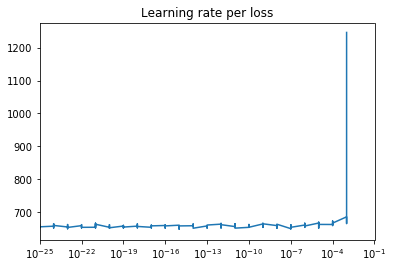

In [114]:
lr = results['lr']
loss =results['loss']
lr = lr.to_numpy()
loss = loss.to_numpy()
lr = lr[:,None]
loss = loss[:,None]

plt.semilogx(lr, loss)
plt.xlim([1e-25, 1e-1])
plt.title("Learning rate per loss")
plt.show()

In [115]:
lr = 1e-4

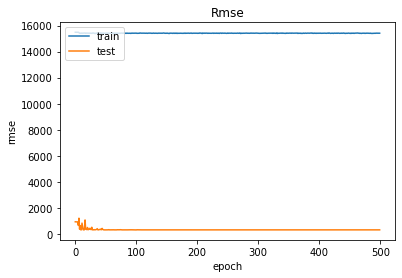

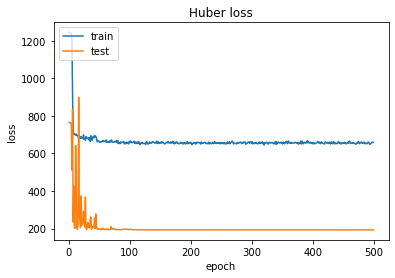

In [116]:
acc = results['root_mean_squared_error']
val_acc = results['val_root_mean_squared_error']
loss = results['loss']
val_loss = results['val_loss']
epochs = range(len(acc))

# Root mean squared error plots
plt.plot(acc)
plt.plot(val_acc)
plt.title('Rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loss plots
plt.plot(loss)
plt.plot(val_loss)
plt.title('Huber loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [117]:
##%tensorboard --logdir logs/fit

In [125]:
test_size = x_test.shape[0]
variance =0.0

percentages = []

for i in range(test_size):
    pred = int(model.predict(x_test[i:i+1]))
    actual = y_test.iloc[i]
    percentages.append(int(abs(pred-actual)/actual*100))
    
percentages.sort()

# Let's round the percentages list to 5 percent
for i, _ in enumerate(percentages):
    value = round(percentages[i]/5.0) * 5.0
    percentages[i] = value

# Make sure numpy is imported -> to create a list of unique percentages
uniques_list = np.unique(percentages)
print(percentages)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 40.0, 40.0, 40.0, 40.0, 45.0, 50.0, 50.0, 50.0, 55.0, 60.0, 60.0, 65.0, 65.0, 65.0, 85.0, 95.0, 3305.0]


In [120]:
def count_uniques(original, uniques):
    unique_count = []
    for i in uniques:
        unique_count.append(original.count(i))
    return unique_count

In [122]:
count_list = count_uniques(percentages, uniques_list)

Text(0, 0.5, 'Relative frequency')

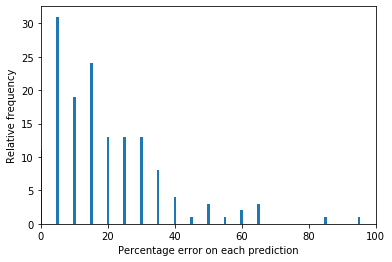

In [130]:
graph = plt.bar(uniques_list, count_list)
plt.xlim(0, 100)
plt.xlabel("Percentage error on each prediction")
plt.ylabel("Relative frequency")

In [129]:
for i in range(round(len(percentages)*0.80)):
    print(percentages[i])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
10.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
20.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
25.0
30.0
30.0
30.0
30.0
30.0
30.0
30.0
30.0
